In [1]:
import jax
import jax.numpy as jnp
import approx_post
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers

Plot settings:

In [2]:
# Plot theme:
sns.set_theme(style='darkgrid')

Save directory for figs:

In [3]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

# Create Model + Data

In [4]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta, 0)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [5]:
# First, let's define a model:
ndim = 1
model_func = lambda theta, x: theta**2
model, model_grad = approx_post.models.from_jax(model_func)

In [6]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([2.25])
noise_cov = jnp.identity(ndim)
num_samples = 1
data = create_data(model_func, true_theta, noise_cov, num_samples, ndim, prngkey)
print(data)

[[3.7179594]]


In [7]:
# Create Gaussian approximate distribution:
approx_dist = approx_post.distributions.approx.Gaussian(ndim)

In [8]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

# Reverse KL Approximation

In [9]:
reverse_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(reverse_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 5.57135009765625, Params = Jaxtainer({'mean': DeviceArray([-0.1], dtype=float32), 'log_chol_diag': DeviceArray([0.1], dtype=float32)})
Loss = 5.546684265136719, Params = Jaxtainer({'mean': DeviceArray([-0.19990426], dtype=float32), 'log_chol_diag': DeviceArray([0.08714806], dtype=float32)})
Loss = 5.51271390914917, Params = Jaxtainer({'mean': DeviceArray([-0.2923392], dtype=float32), 'log_chol_diag': DeviceArray([0.04673734], dtype=float32)})
Loss = 5.481539249420166, Params = Jaxtainer({'mean': DeviceArray([-0.3773647], dtype=float32), 'log_chol_diag': DeviceArray([0.00985686], dtype=float32)})
Loss = 5.472437858581543, Params = Jaxtainer({'mean': DeviceArray([-0.46023622], dtype=float32), 'log_chol_diag': DeviceArray([-0.01154138], dtype=float32)})
Loss = 5.465576171875, Params = Jaxtainer({'mean': DeviceArray([-0.5420956], dtype=float32), 'log_chol_diag': DeviceArray([-0.02153166], dtype=float32)})
Loss = 5.457200050354004, Params = Jaxtainer({'mean': DeviceArray([-0.61892474

# Forward KL Approximation

In [10]:
forward_approx = approx_post.distributions.approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(forward_approx, loss, data, prngkey, verbose=True, max_iter=50, num_samples=1000)

Loss = 0.0026455181650817394, Params = Jaxtainer({'mean': DeviceArray([0.09998727], dtype=float32), 'log_chol_diag': DeviceArray([0.09999955], dtype=float32)})
Loss = 0.0024301582016050816, Params = Jaxtainer({'mean': DeviceArray([0.11192022], dtype=float32), 'log_chol_diag': DeviceArray([0.19813511], dtype=float32)})
Loss = 0.002253767568618059, Params = Jaxtainer({'mean': DeviceArray([0.07492207], dtype=float32), 'log_chol_diag': DeviceArray([0.29270077], dtype=float32)})
Loss = 0.002132576424628496, Params = Jaxtainer({'mean': DeviceArray([0.01923863], dtype=float32), 'log_chol_diag': DeviceArray([0.382097], dtype=float32)})
Loss = 0.0020544917788356543, Params = Jaxtainer({'mean': DeviceArray([-0.0431693], dtype=float32), 'log_chol_diag': DeviceArray([0.46490818], dtype=float32)})
Loss = 0.002004615729674697, Params = Jaxtainer({'mean': DeviceArray([-0.1023852], dtype=float32), 'log_chol_diag': DeviceArray([0.5398858], dtype=float32)})
Loss = 0.0019668107852339745, Params = Jaxtain

# Plots

Create true posterior:

In [11]:
true_posterior = computation_helpers.construct_true_posterior(model_func, noise_cov, prior_mean, prior_cov,
                                                              theta_lims=(-4.5,4.5))

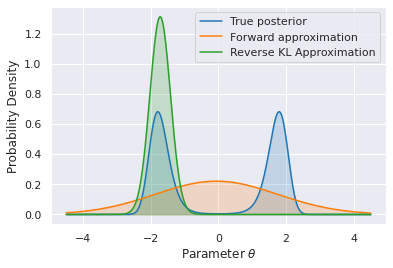

In [12]:
theta_plot = jnp.linspace(-4.5,4.5,1000).reshape(-1,1)
pdfs = {'True posterior': true_posterior(theta_plot, data, 0),
        'Forward approximation': jnp.exp(forward_approx.logpdf(theta_plot)),
        'Reverse KL Approximation': jnp.exp(reverse_approx.logpdf(theta_plot))}
plotting_helpers.plot_distributions(pdfs, theta_plot, 'Parameter $\\theta$')
plt.savefig(os.path.join(fig_save_dir, 'nonamortised_vi.pdf'), bbox_inches='tight')